#### Student Name: Dima Frank

#### Studen id: 327314308

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor
from scipy import stats

from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from pandas.plotting import scatter_matrix

In [2]:
# pip install pyarrow

# Question 1

In [3]:
data1 = pd.read_parquet('data1.parquet', engine='pyarrow')

In [4]:
data1.head(10)

,x,y
0,12.209516,36.021575
1,62.623142,162.746072
2,-14.712353,166.459738
3,130.624579,551.308062
4,121.652246,208.207596
5,53.244766,210.445025
6,169.351484,722.974727
7,134.692400,463.214255
8,-45.130682,4.321998
9,169.558196,760.244366


In [5]:
data1.shape

(103, 2)

<AxesSubplot:xlabel='x', ylabel='y'>

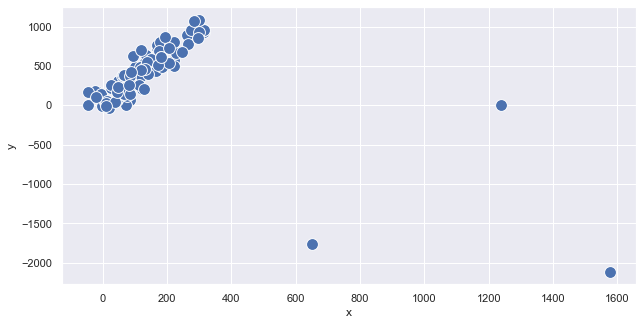

In [6]:
sns.set(rc={'figure.figsize':(10.3,5.1)})
sns.scatterplot(data=data1, x='x', y='y', s=140)

#### Manually cleaning the outliers.

In [7]:
data1_clean = data1[data1['x']<600]
data1_clean.shape

(100, 2)

<AxesSubplot:xlabel='x', ylabel='y'>

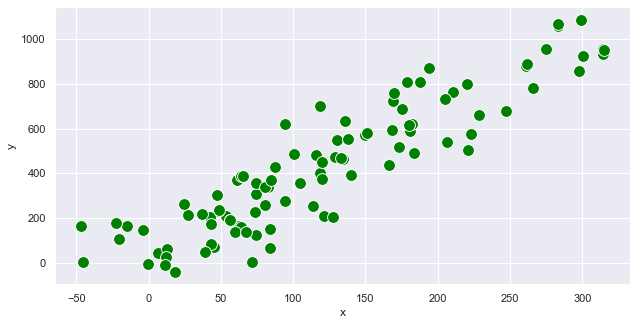

In [8]:
sns.set(rc={'figure.figsize':(10.3,5.1)})
sns.scatterplot(data=data1_clean, x='x', y='y', s=140, color='green')

Looks like there is strong linear relationship between predictor and responce.

I will try to build simple linear regression in order to model y as function of x.

R^2 = 0.8358


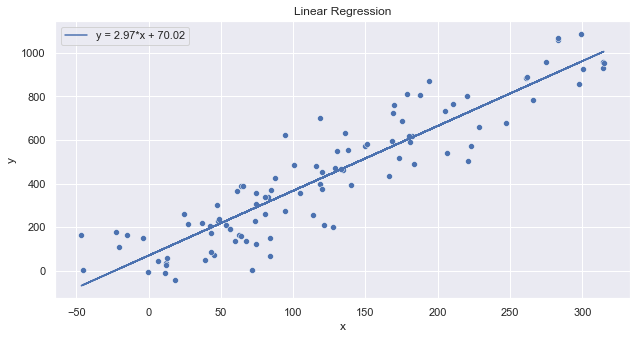

In [9]:
X = np.array(data1_clean['x']).reshape(-1,1)
y = np.array(data1_clean['y']).reshape(-1,1)

LinReg = LinearRegression().fit(X, y)
sns.scatterplot(data=data1_clean, x='x', y='y').set(title='Linear Regression')
LinReg_predicted_y = LinReg.predict(X)
plt.plot(X, LinReg_predicted_y, label ='y = {}*x + {}'.format(round(LinReg.coef_[0][0],2), round(LinReg.intercept_[0],2)))
plt.legend(loc='best')

r_squared = LinReg.score(X, y)
print('R^2 = {}'.format(round(r_squared,4)))

Looks like the line of simple Linear Regression fits the data pretty good, as R-squared is almost 84%, which means that 84% of variance in y can be explained by variance in x.

We can also take a look on residuals, to make sure that there is no heteroskedasticity, and the basic Linear Regression assumption is met.

Text(0.5, 1.0, 'Residuals')

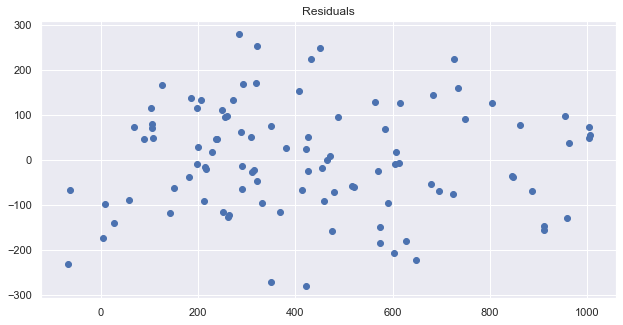

In [10]:
residuals = LinReg_predicted_y - y
plt.scatter(x=LinReg_predicted_y, y=residuals)
plt.title('Residuals')

There is no heteroskedasticity in our data.

We know that: 

"The technique used for measuring 𝑥 is twice as better than that for
measuring 𝑦 in the sense of error variance, i.e. the variance of the error in 𝑥 is twice
as small as the variance of error in 𝑦".


In order to restore the true function of x (taking in account that the x measured with errors), Wikipedia says that we can use something called Deming regression. We will try to get the true relationship between x and y, by calculating expressions below.

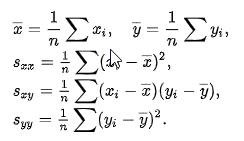

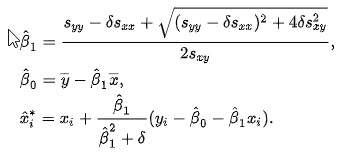

In [11]:
mean_x = data1_clean['x'].mean()
mean_y = data1_clean['y'].mean()
cov = data1_clean.cov()
s_xx = cov['x']['x']
s_xy = cov['x']['y']
s_yy = cov['y']['y']

delta = 1/2 # ratio of measurement errors

slope = (s_yy  - delta * s_xx + np.sqrt((s_yy - delta * s_xx) ** 2 + 4 * delta * s_xy ** 2)) / (2 * s_xy)
intercept = mean_y - slope  * mean_x

In [12]:
print('y = {} + {}*x'.format(round(intercept,2), round(slope,2)))

y = 2.77 + 3.53*x


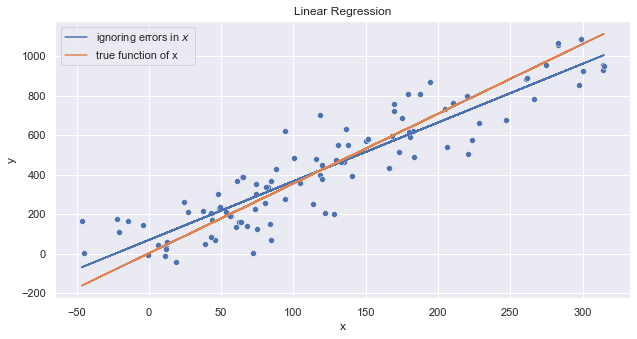

In [13]:
# data1_clean.plot.scatter('x', 'y', title='linear regression with & without accounting for $x$ error measurements')
sns.scatterplot(data=data1_clean, x='x', y='y').set(title='Linear Regression')
plt.plot(data1_clean['x'], LinReg_predicted_y, label='ignoring errors in $x$')
# X = [data1_clean['x'].min(), data1_clean['x'].max()]

def f(x):
    return x*slope+intercept

true_y = f(data1_clean['x'])
plt.plot(data1_clean['x'], true_y, label='true function of x')
plt.legend(loc='best')

Lets check if the new line better fit the data then the simple Linear Regression that we used before.

In [14]:
r_squared_true = LinReg.score(X, true_y)
print('R^2 = {}'.format(round(r_squared_true,8)))

R^2 = 0.9750653


<span style="color:black;font-weight:680;font-size:20px"> 
Summary:
</span>


<ul>
    <li>
Because the new R-squared is higher than the previous one and almost strive to 1, these means that the new function that we found   
        
y = 2.77 + 3.53*x    
has better prediction power.
        </li> 
</ul>

         

# Question 2

<span style="color:blue;font-weight:680;font-size:20px"> 
Linear Regression assumptions:
</span>
<ul>
    <li>Linear relationship.</li>
    <li>Normality of the residuals.</li>
    <li>No or little multicollinearity.</li>
    <li>Homoscedasticity.</li>
</ul>



We will check all these assumptions first, in order to understand if using a simple Linear regression in this case is a good idea.

In [15]:
data2 = pd.read_parquet('data2.parquet', engine='pyarrow')

In [16]:
data2.head(10)

,x,y
0,0.000000,10.248357
1,0.101010,9.974390
2,0.202020,10.490277
3,0.303030,11.143792
4,0.404040,10.037640
5,0.505051,10.076331
6,0.606061,11.571186
7,0.707071,11.008568
8,0.808081,9.979617
9,0.909091,10.972444


In [17]:
data2.shape

(100, 2)

At a first look, seems like there is a midle-strong linear relationship beetween predctor and response variable.

However, the correlation matrix below tells us that there is only 0.46 of Pearson correlation coefficient between the variables.

<AxesSubplot:xlabel='x', ylabel='y'>

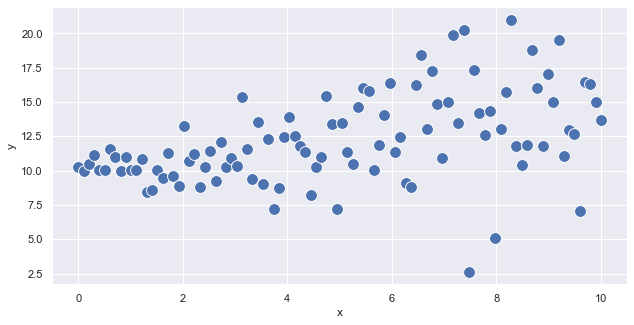

In [18]:
sns.scatterplot(data=data2, x='x', y='y', s=140)

In [19]:
data2.corr()

,x,y
x,1.000000,0.459861
y,0.459861,1.000000


### Building simple Linear Regression model. 

In [20]:
X = data2['x']
Y = data2['y']
X = sm.add_constant(X)
model = sm.OLS(Y, X, missing='drop')
model_result = model.fit()
model_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.203
Method:                 Least Squares   F-statistic:                     26.28
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           1.48e-06
Time:                        17:17:47   Log-Likelihood:                -248.23
No. Observations:                 100   AIC:                             500.5
Df Residuals:                      98   BIC:                             505.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6752      0.581     16.660      0.000       8.523      10.828
x              0.5144      0.100      5.127      0.000       0.315       0.713
==============================================================================
Omnibus:                       12.551   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.650
Skew:                          -0.497   Prob(JB):                     1.99e-05
Kurtosis:                       5.051   Cond. No.                         11.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Cheking residuals distribution

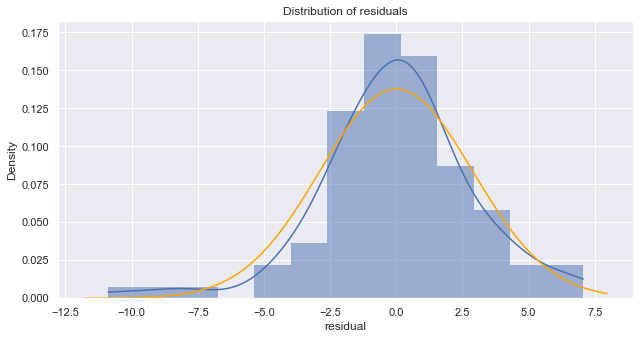

In [21]:
mu, std = stats.norm.fit(model_result.resid)
mu, std

fig, ax = plt.subplots()
# plot the residuals
sns.histplot(x=model_result.resid, ax=ax, stat="density", linewidth=0, kde=True)
ax.set(title="Distribution of residuals", xlabel="residual")

# plot corresponding normal curve
xmin, xmax = plt.xlim() # the maximum x values from the histogram above
x = np.linspace(xmin, xmax, 100) # generate some x values
p = stats.norm.pdf(x, mu, std) # calculate the y values for the normal curve
sns.lineplot(x=x, y=p, color="orange", ax=ax)
plt.show()

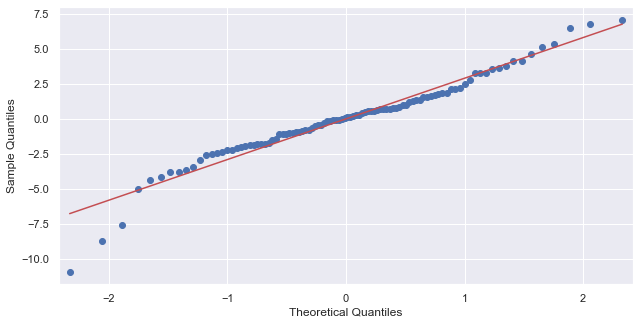

In [22]:
sm.qqplot(model_result.resid, line='s');

#### Cheking Homoscedasticity

We want to check if the error is constant along the values of the dependent variable.

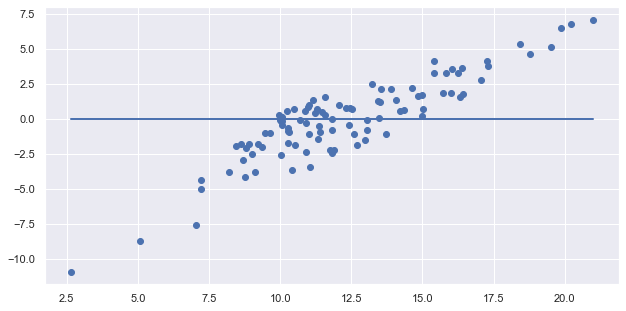

In [23]:
plt.scatter(Y, model_result.resid)
plt.plot(Y, [0]*len(Y))

##### The p-value, in this case, is very small and we, therefore, reject the null hypothesis and confirm that there is potential heteroscedasticity in the dataset.

In [24]:
from statsmodels.stats.diagnostic import het_white
from statsmodels.compat import lzip
from patsy import dmatrices

expr = 'y~ X'
y, X = dmatrices(expr, data2, return_type='dataframe')

keys = ['Lagrange Multiplier statistic:', 'LM test\'s p-value:', 'F-statistic:', 'F-test\'s p-value:']
results = het_white(model_result.resid, X)
lzip(keys, results)

[('Lagrange Multiplier statistic:', 11.019456296116982),
 ("LM test's p-value:", 0.004047207474894136),
 ('F-statistic:', 6.006297647946954),
 ("F-test's p-value:", 0.0034738428930523152)]

<span style="color:black;font-weight:680;font-size:20px"> 
Summary:
</span>

<ul>
    <li>The negative skewness (-0.497), tells us that the tail of the distribution curve is longer on the left side. So, the residuals are not normally distributed in our model.
Also we can see it in above histogram, that shows that the Normal curve(orange) is not fitting the distribution of residuals(blue curve).
The same thing we can observe in QQ-plot.        
   </li>
    <li>Low R-square indicates that variation of dependent variable (y), is weakly explained by the independent variable X, in this model.</li>
    <li> So, we can conclude that first and second assumptions of Linear regression does not happen is this specific case. The linear relationship between predictor and label is not much strong, and distribution of residuals is not normal.</li>
    <li>The third assumption regards lack of multicollinearity is not relevant in this specific case because we have only one independent variable (x).</li>
    <li>Looks like there is potential heteroskedasticity in our data. The variance of error not seems constant between observations.</li>
    <li>In accordance with the above, we would not like to use Linear regression for this dataset because no assumptions are met.
</ul>












We will use Quantile Regression instead.

### Building Quantile Regression. 

In [25]:
train_df, test_df = train_test_split(data2, test_size=0.10, shuffle=True)

X_train, y_train = train_df[['x']], train_df[['y']]
X_test, y_test = test_df[['x']], test_df[['y']]

In [26]:
classifiers = {}
for tau in [0.05, 0.5, 0.95]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    classifiers[str(tau)] = {'clf': clf, 'predictions': preds}

In [27]:
data = pd.DataFrame({'X': X_test.reset_index()['x'],
              '0.05': classifiers['0.05']['predictions']['0.05'],
              '0.5' : classifiers['0.5']['predictions']['0.5'],
              '0.95': classifiers['0.95']['predictions']['0.95'],
              'y': y_test.reset_index()['y']})

In [28]:
data

,X,0.05,0.5,0.95,y
0,4.646465,8.195439,11.701702,15.256916,11.022742
1,1.111111,8.613982,10.187281,13.611461,10.063952
2,8.282828,8.938401,14.273450,19.528473,21.000932
3,8.585859,8.938401,14.273450,19.528473,11.888043
4,8.686869,8.938401,14.273450,19.528473,18.777124
5,9.595960,8.938401,14.273450,19.528473,7.044307
6,1.818182,8.613982,10.187281,13.611461,9.629602
7,4.949495,9.436396,13.428964,15.415682,7.230148
8,0.000000,8.613982,10.187281,13.611461,10.248357
9,3.333333,8.661112,11.584968,15.122926,9.374960


In [29]:
melted_data = pd.melt(data, id_vars=['X'])

In [30]:
# melted_data

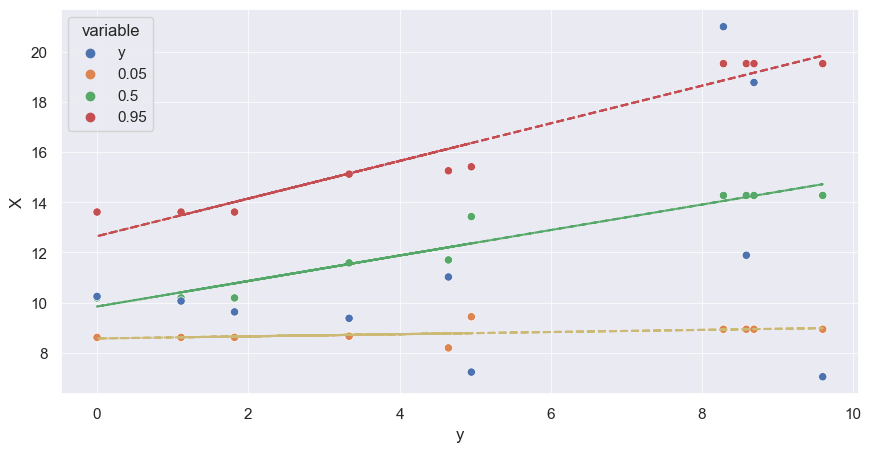

In [31]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data, 
                x="X",
                y='value',
                hue='variable',
                hue_order=['y', '0.05', '0.5', '0.95'],
                marker='o')

m, b = np.polyfit(data['X'], data['0.95'], 1)
plt.plot(data['X'], m*data['X']+b, 'r--')

m, b = np.polyfit(data['X'], data['0.5'], 1)
plt.plot(data['X'], m*data['X']+b, 'g--')

m, b = np.polyfit(data['X'], data['0.05'], 1)
plt.plot(data['X'], m*data['X']+b, 'y--')


plt.grid(linestyle='-', linewidth=0.5)
ylabel = plt.ylabel("X")
xlabel = plt.xlabel("y")

### Explanation of quantile regression

Quantile regression allows multiple quantiles to be modelled. 
It can allow for a more comprehensive analysis of the data to be carried out compared to least-squares regression where only the mean is considered. This potentially enables more insight into the data and any underlying relationships, in addition, it will tend to be less sensitive to large outlying observations.

# Question 3

In [32]:
data3 = pd.read_parquet('data3.parquet', engine='pyarrow')

In [33]:
data3.shape

(506, 14)

In [34]:
data3.head(5)

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


#### Checking distribution of features and label 

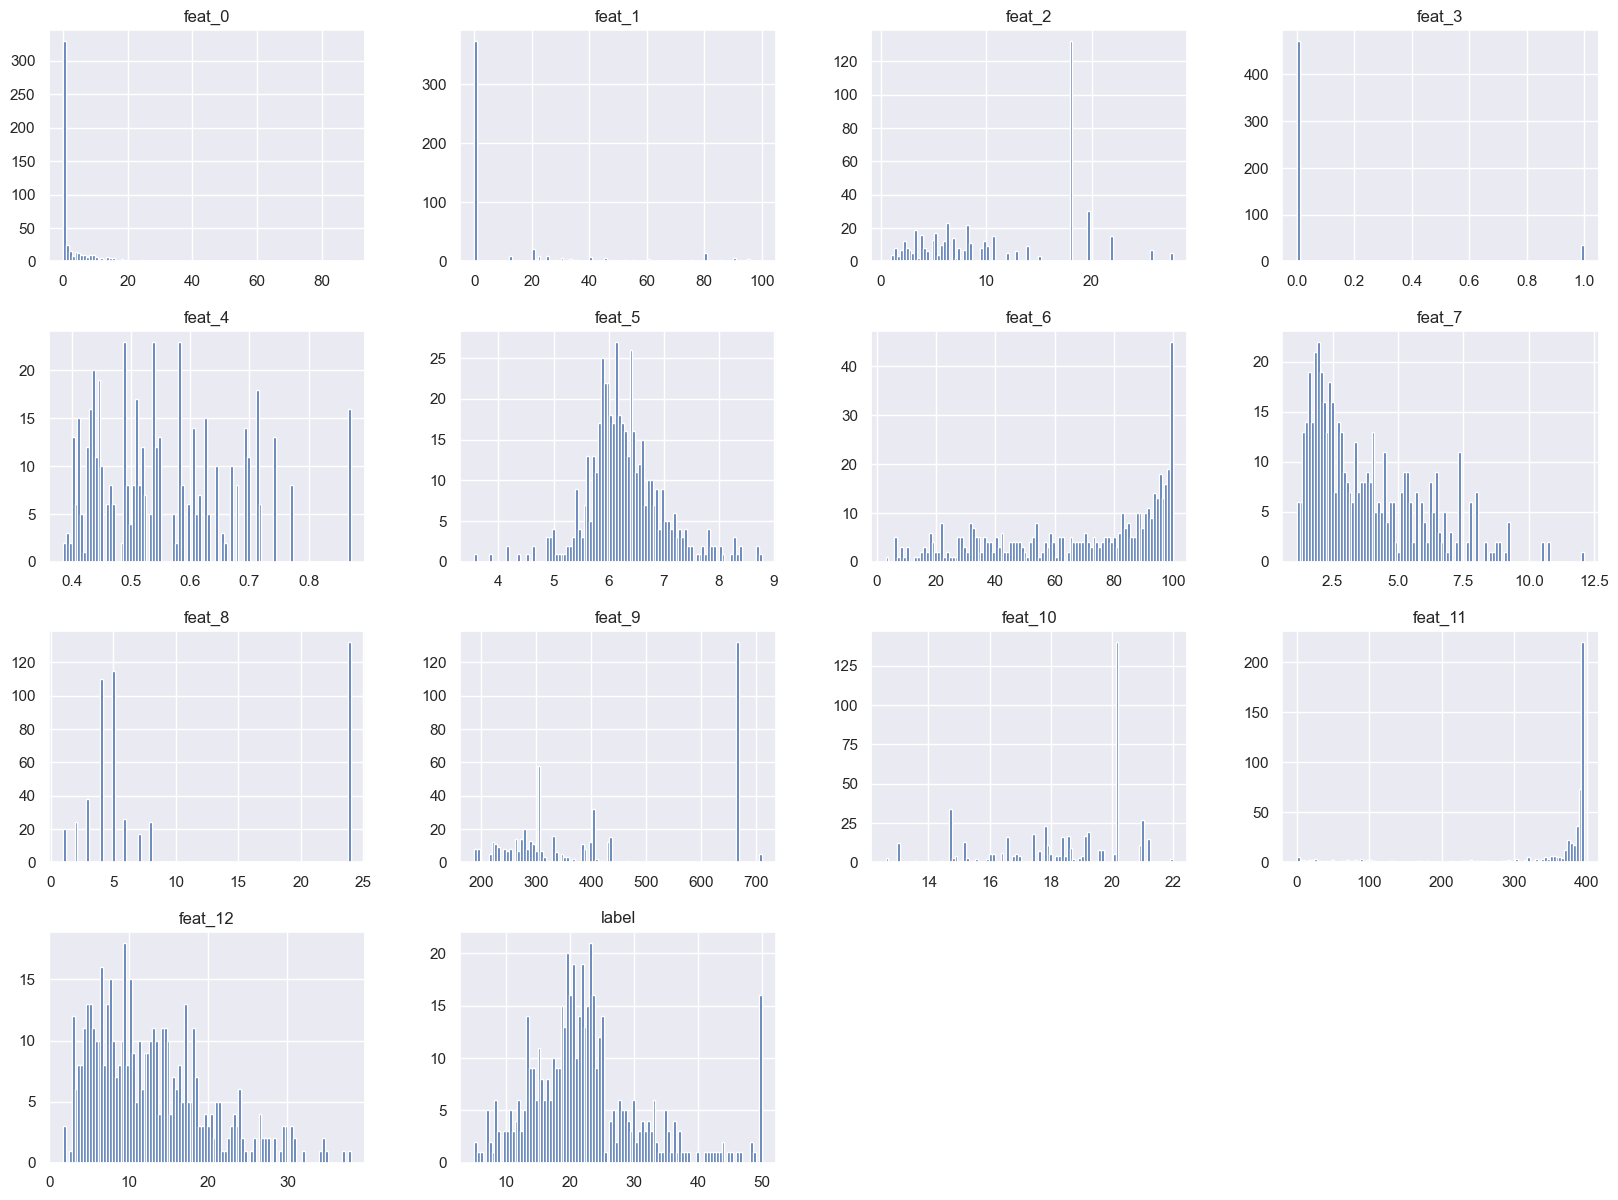

In [35]:
_ = data3.hist(bins=100, figsize=(20,15))

In [36]:
data3.describe()

,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,feat_11,feat_12,label
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [37]:
data3.dtypes

feat_0     float64
feat_1     float64
feat_2     float64
feat_3       int64
feat_4     float64
feat_5     float64
feat_6     float64
feat_7     float64
feat_8       int64
feat_9     float64
feat_10    float64
feat_11    float64
feat_12    float64
label      float64
dtype: object

#### Cleaning Data

In [38]:
data3.columns = data3.columns.str.replace('_', '') # Replace _ symbol from column names
data3.columns

Index(['feat0', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'feat7',
       'feat8', 'feat9', 'feat10', 'feat11', 'feat12', 'label'],
      dtype='object')

In [39]:
print('There are {} null values in the data.'.format(data3.isnull().sum().sum()))

There are 0 null values in the data.


#### Correlations 

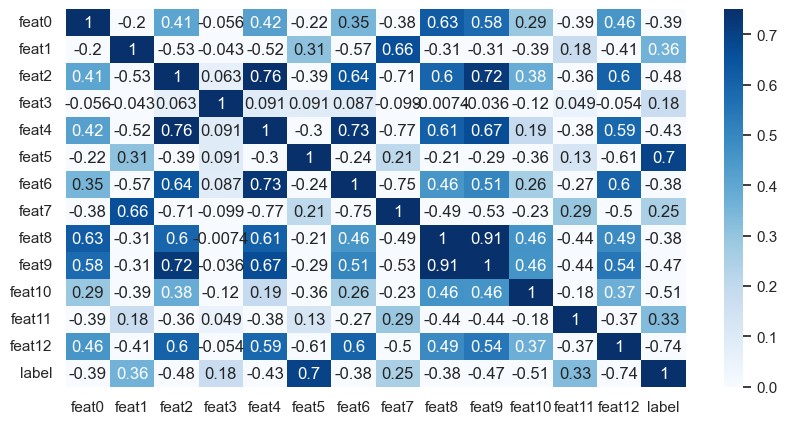

In [40]:
sns.set(rc={"figure.figsize":(10, 5)})
corrmatrix=data3.corr()
sns.heatmap(corrmatrix, cmap="Blues", annot= True, vmin=0, vmax=0.75)
plt.show()

##### Plot Outliers 

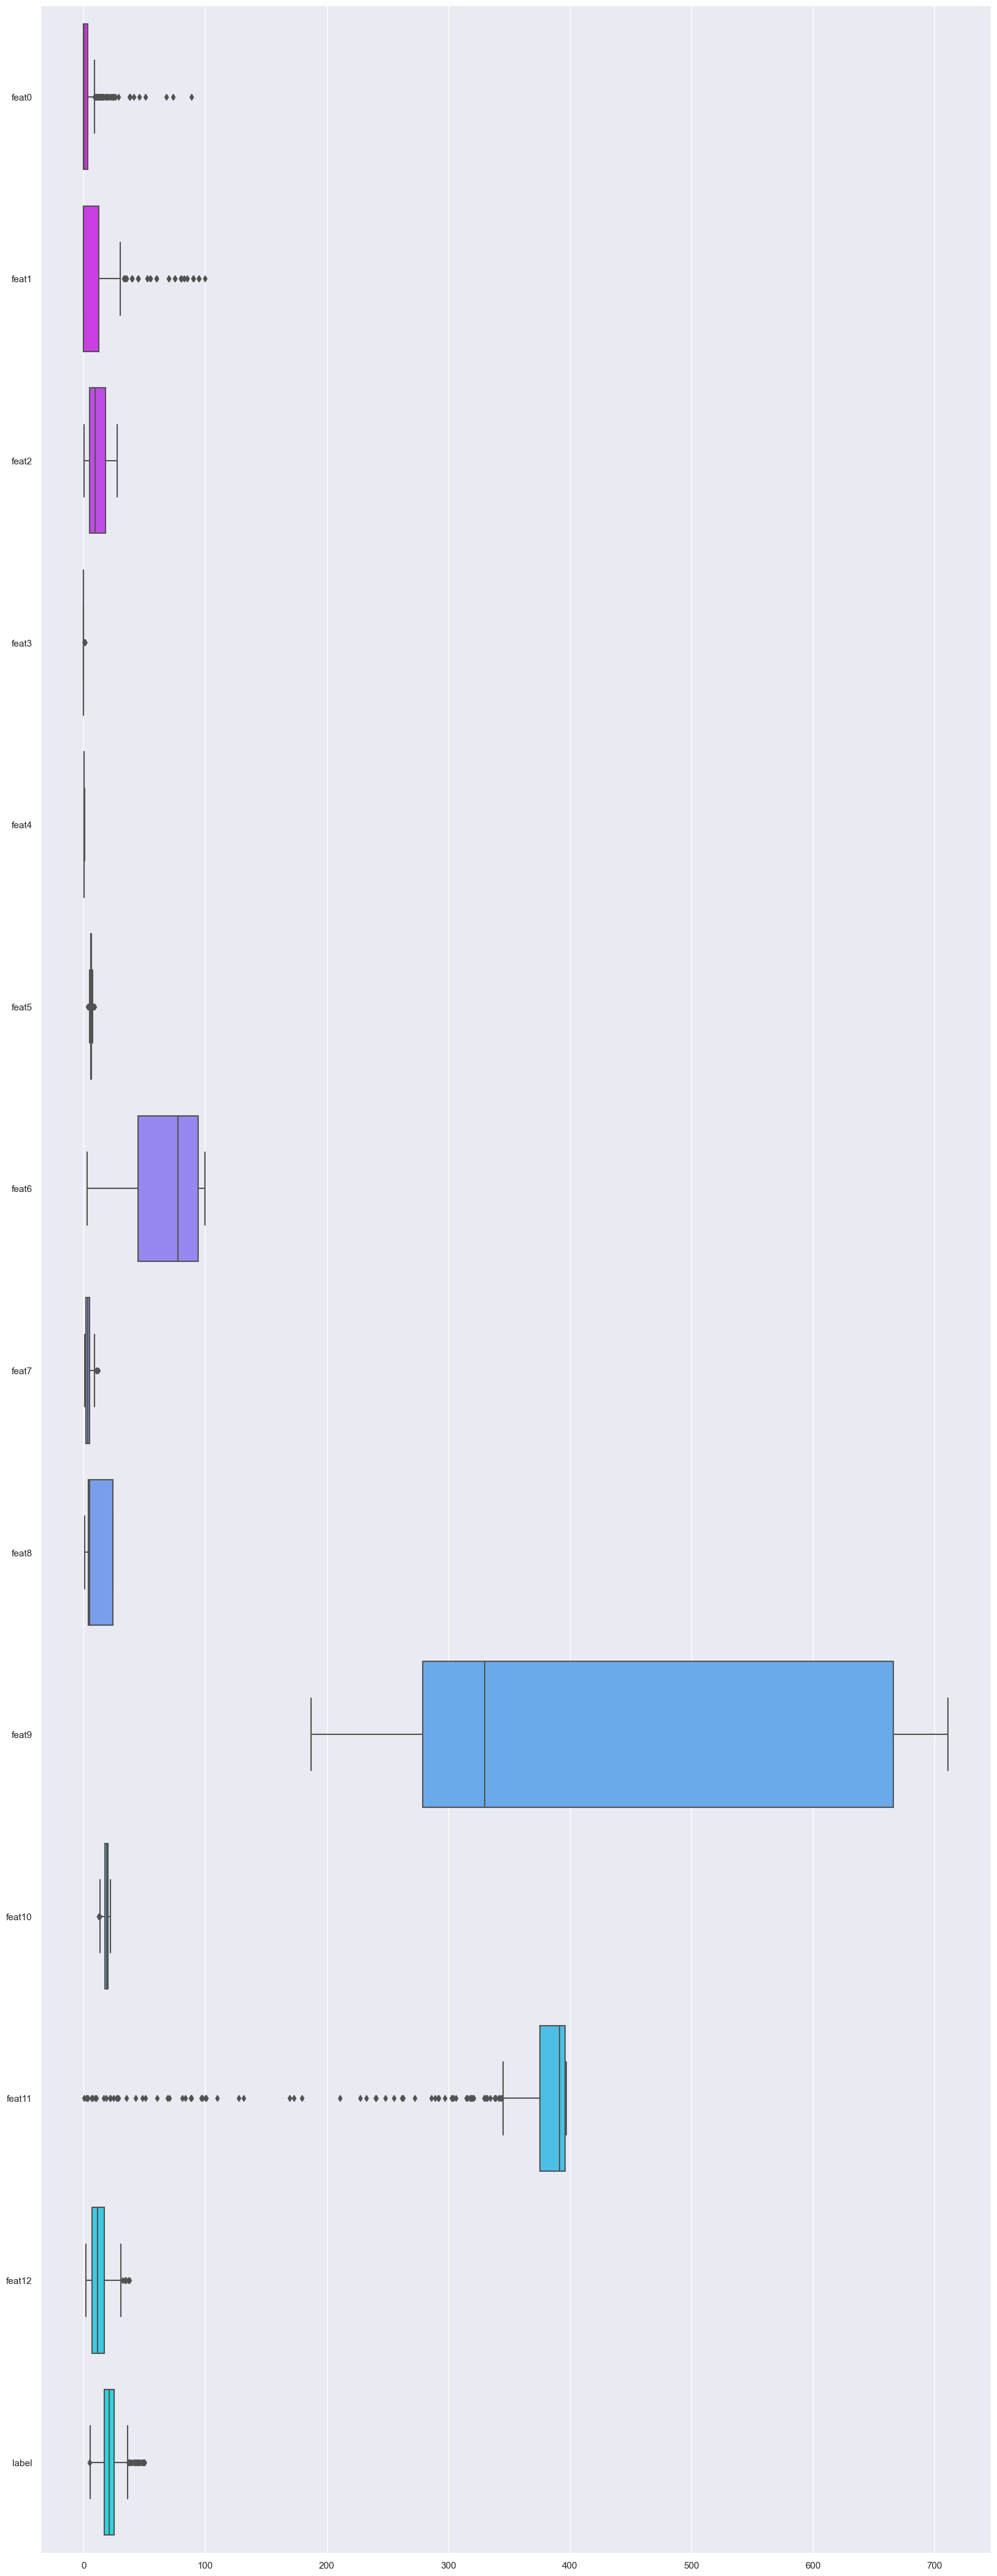

In [41]:
sns.set(rc={"figure.figsize":(20, 55)})
ax = sns.boxplot(data=data3[data3.columns], orient="h", palette="cool_r")

#### Log Transformation 

In [42]:
np.seterr(divide = 'ignore') 
data3_transformed=np.log(data3)
np.seterr(divide = 'warn') 

data3_transformed = data3_transformed.replace([np.inf, -np.inf], 0.0)

data3_transformed

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,label
0,-5.064036,2.890372,0.837248,0.0,-0.619897,1.883275,4.177459,1.408545,0.000000,5.690359,2.727853,5.983684,1.605430,3.178054
1,-3.600502,0.000000,1.955860,0.0,-0.757153,1.859574,4.368181,1.602836,0.693147,5.488938,2.879198,5.983684,2.212660,3.072693
2,-3.601235,0.000000,1.955860,0.0,-0.757153,1.971996,4.112512,1.602836,0.693147,5.488938,2.879198,5.973377,1.393766,3.546740
3,-3.430523,0.000000,0.779325,0.0,-0.780886,1.945624,3.824284,1.802073,1.098612,5.402677,2.928524,5.977949,1.078410,3.508556
4,-2.672924,0.000000,0.779325,0.0,-0.780886,1.966693,3.992681,1.802073,1.098612,5.402677,2.928524,5.983684,1.673351,3.589059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-2.770511,0.000000,2.479056,0.0,-0.556870,1.886008,4.235555,0.907694,0.000000,5.609472,3.044522,5.971236,2.269028,3.109061
502,-3.095111,0.000000,2.479056,0.0,-0.556870,1.811562,4.339902,0.827460,0.000000,5.609472,3.044522,5.983684,2.206074,3.025291
503,-2.800824,0.000000,2.479056,0.0,-0.556870,1.942476,4.510860,0.773574,0.000000,5.609472,3.044522,5.983684,1.729884,3.173878
504,-2.211009,0.000000,2.479056,0.0,-0.556870,1.916040,4.492001,0.870833,0.000000,5.609472,3.044522,5.974954,1.868721,3.091042


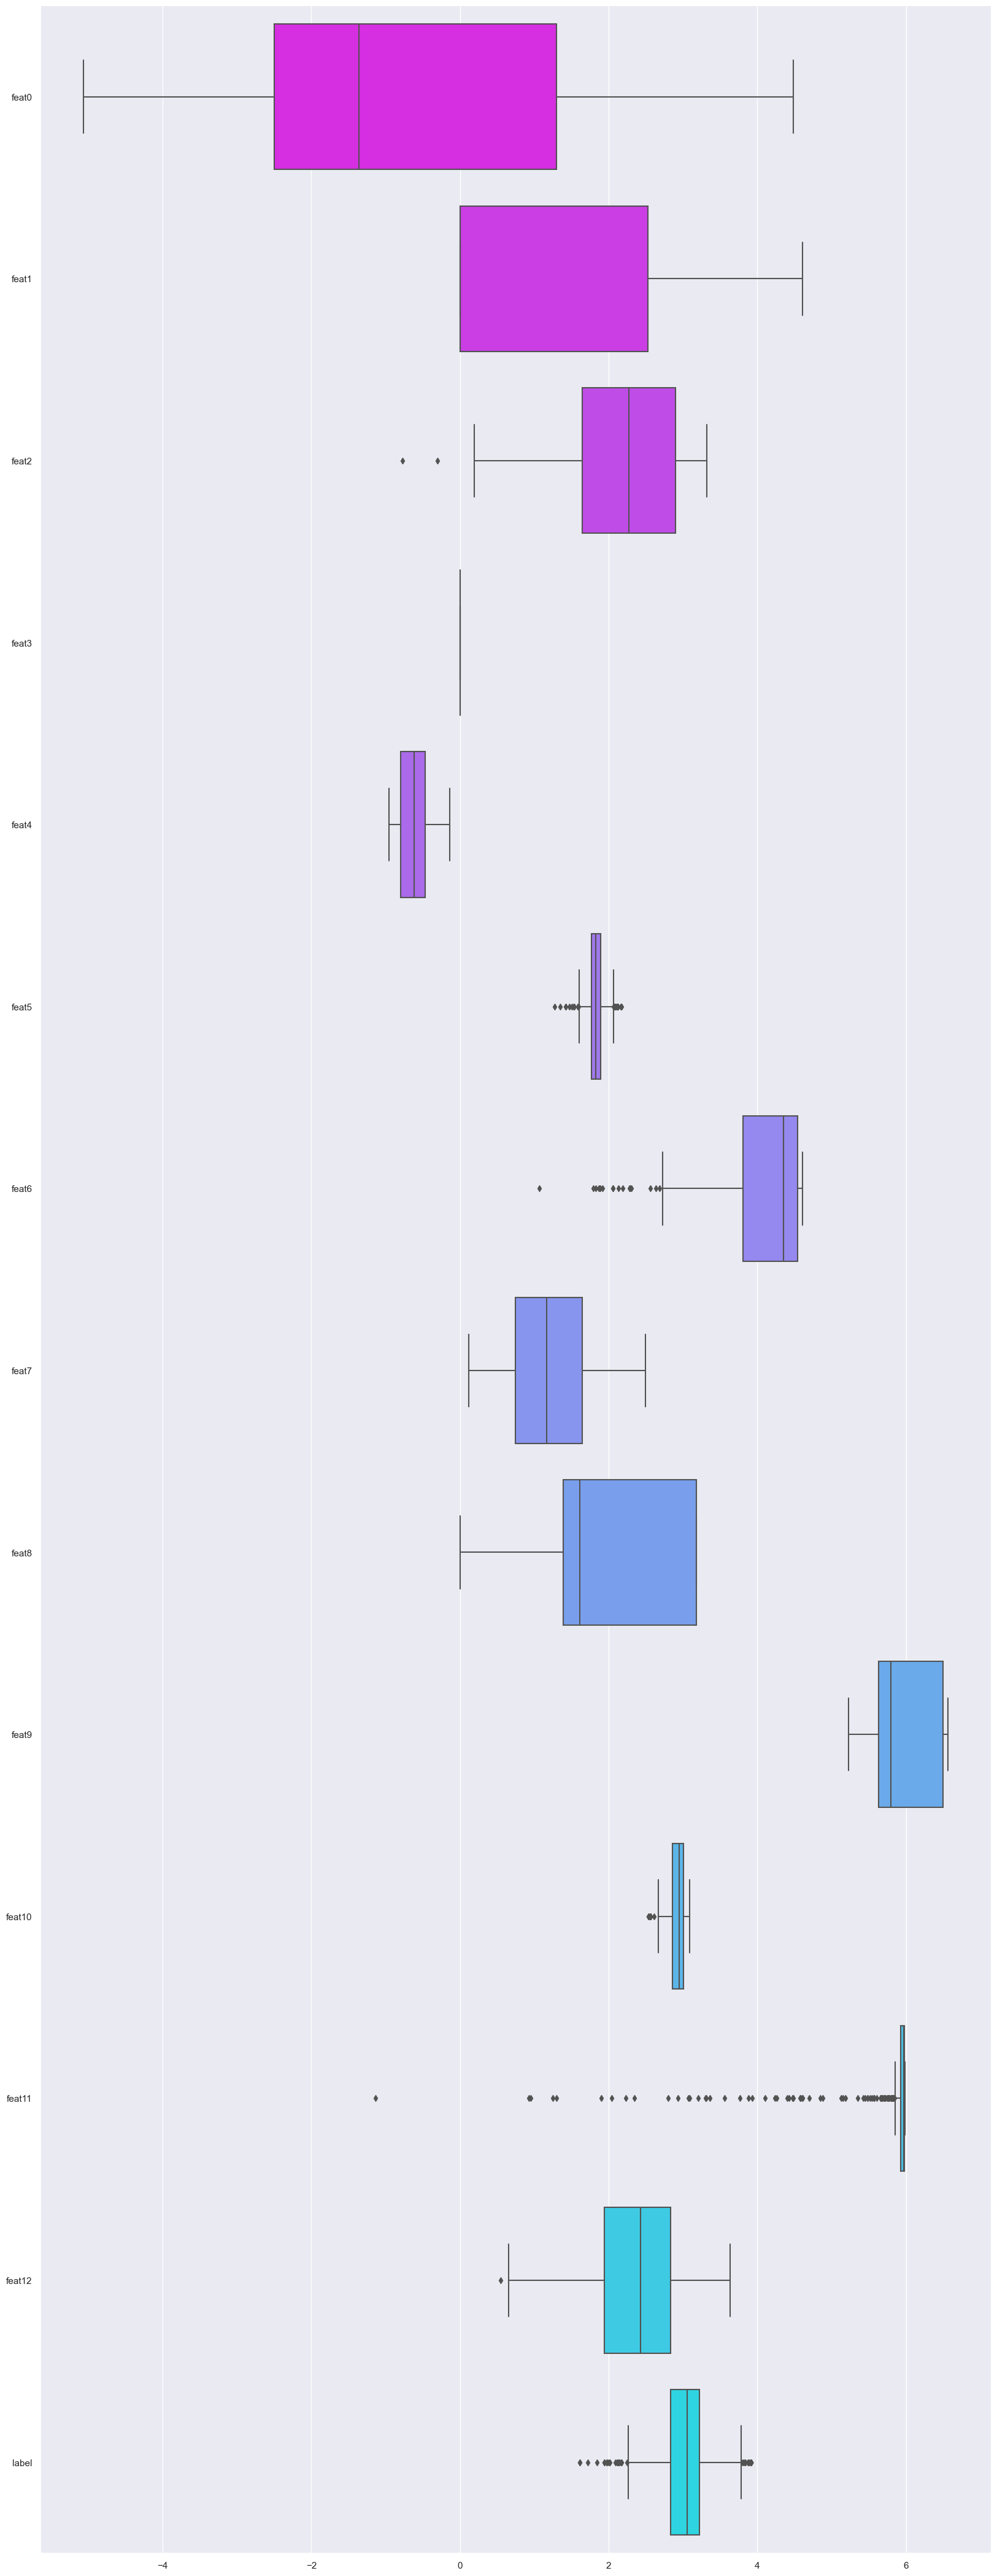

In [43]:
sns.set(rc={"figure.figsize":(20, 55)})
ax = sns.boxplot(data=data3_transformed[data3_transformed.columns], orient="h", palette="cool_r")

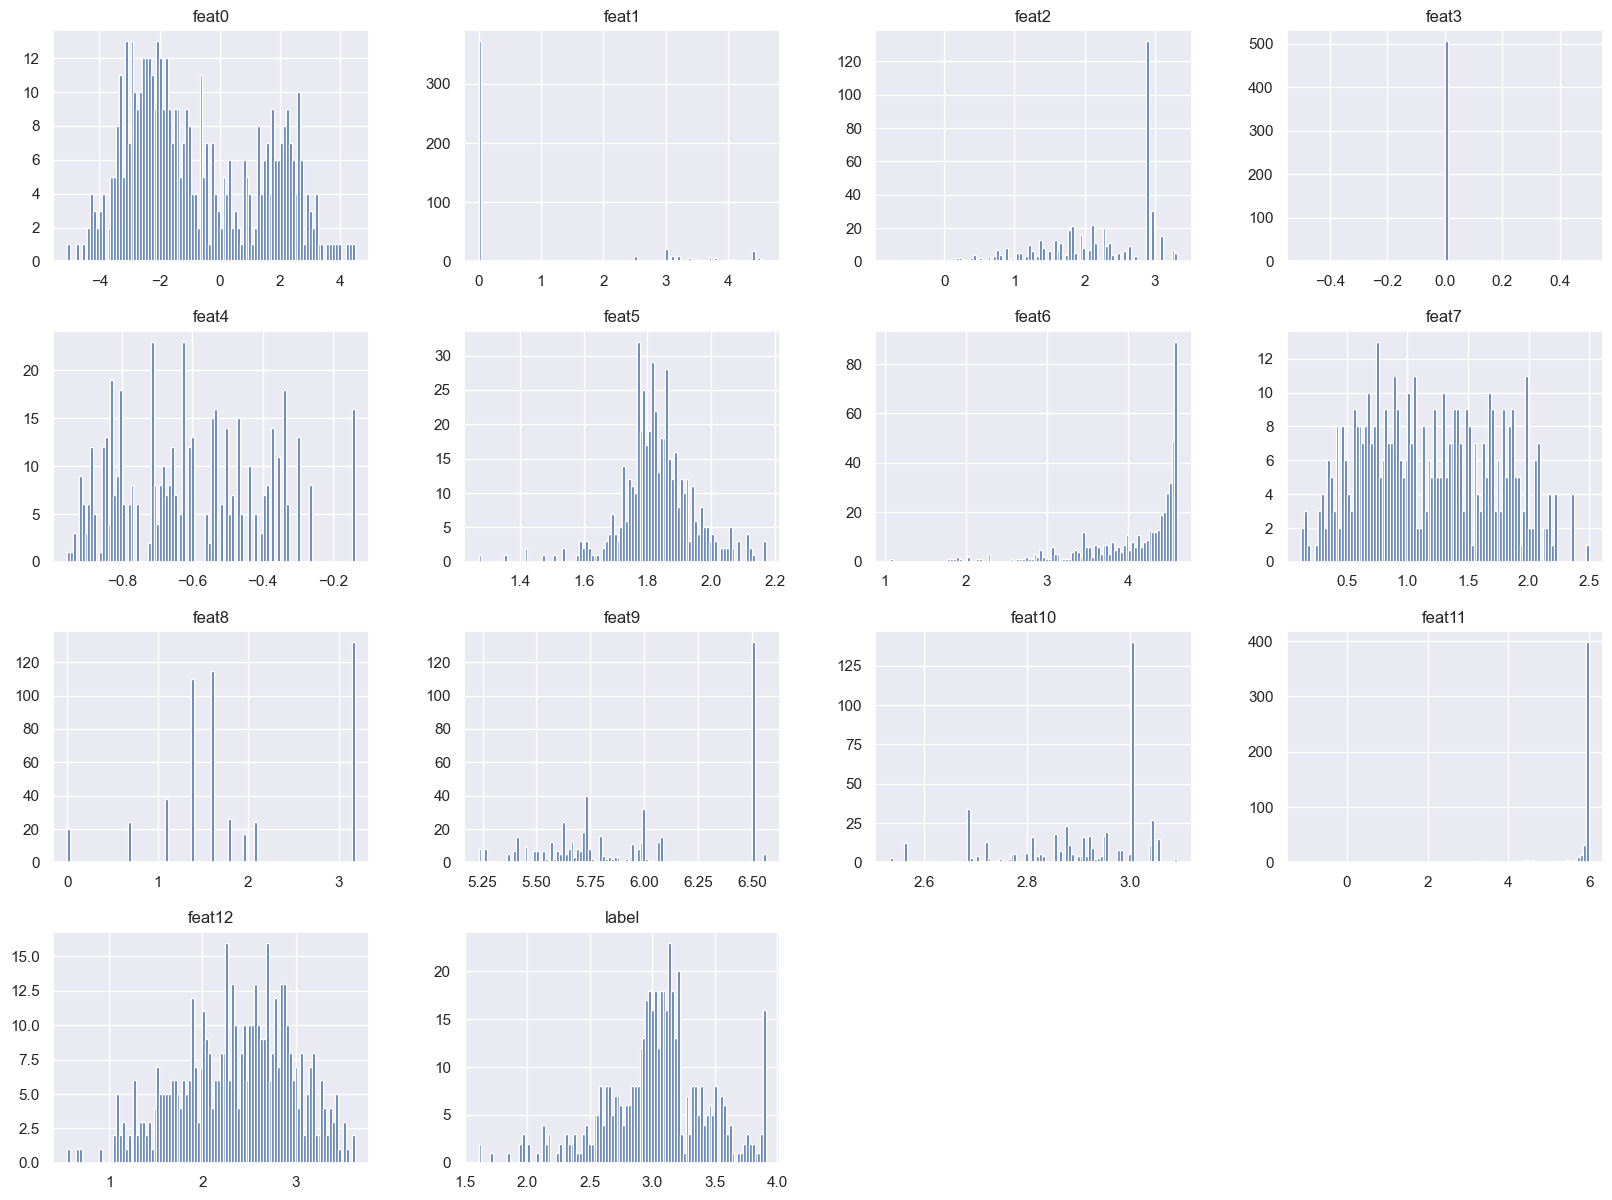

In [44]:
_ = data3_transformed.hist(bins=100, figsize=(20,15))

#### Moving outliers 

In [45]:
procentile_025 =data3_transformed.quantile(0.25)
procentile_075 = data3_transformed.quantile(0.75)
IQR = procentile_075 - procentile_025
print(IQR)

feat0     3.802608
feat1     2.525729
feat2     1.249178
feat3     0.000000
feat4     0.329127
feat5     0.118132
feat6     0.736875
feat7     0.904379
feat8     1.791759
feat9     0.870078
feat10    0.149212
feat11    0.054050
feat12    0.891833
label     0.384196
dtype: float64


In [46]:
outdf = data3_transformed[((data3_transformed > procentile_025) & (data3_transformed < (procentile_075))).any(axis=1)]
outdf.shape

(490, 14)

In [47]:
data3.shape

(506, 14)

##### Scaling 

In [48]:
scaler=StandardScaler()
scaled=scaler.fit_transform(outdf)
scaled=pd.DataFrame(scaled, columns=data3_transformed.columns )
scaled

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,label
0,-1.988073,1.179155,-1.671423,0.0,-0.010805,0.428445,0.168137,0.369089,-2.134593,-0.572491,-1.409993,0.302990,-1.264729,0.316130
1,-1.290341,-0.601157,-0.232016,0.0,-0.697790,0.205149,0.479219,0.737464,-1.323804,-1.090895,-0.203467,0.302990,-0.226108,0.045724
2,-1.290690,-0.601157,-0.232016,0.0,-0.697790,1.264327,0.062202,0.737464,-1.323804,-1.090895,-0.203467,0.289812,-1.626763,1.262356
3,-1.209304,-0.601157,-1.745956,0.0,-0.816581,1.015872,-0.407919,1.115215,-0.849522,-1.312905,0.189752,0.295657,-2.166156,1.164358
4,-0.848122,-0.601157,-1.745956,0.0,-0.816581,1.214367,-0.133251,1.115215,-0.849522,-1.312905,0.189752,0.302990,-1.148554,1.370968
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-0.894646,-0.601157,0.441221,0.0,0.304655,0.454202,0.262895,-0.580521,-2.134593,-0.780673,1.114495,0.287075,-0.129695,0.139061
486,-1.049398,-0.601157,0.441221,0.0,0.304655,-0.247193,0.433093,-0.732645,-2.134593,-0.780673,1.114495,0.302990,-0.237373,-0.075933
487,-0.909098,-0.601157,0.441221,0.0,0.304655,0.986207,0.711938,-0.834810,-2.134593,-0.780673,1.114495,0.302990,-1.051859,0.305414
488,-0.627907,-0.601157,0.441221,0.0,0.304655,0.737142,0.681179,-0.650409,-2.134593,-0.780673,1.114495,0.291828,-0.814391,0.092817


#### Modeling

In [49]:
X = scaled.drop('label', axis=1)
y = scaled['label']

In [50]:
ridge = Ridge()

In [51]:
params={'alpha' :np.arange(0, 1.01, 0.01)}
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=123) # Define cross-validation method

In [52]:
ridge_regressor = GridSearchCV(ridge, params, scoring='neg_mean_absolute_error', cv=cv )

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [54]:
ridge_regressor.fit(x_train,y_train)

GridSearchCV(cv=RepeatedKFold(n_repeats=3, n_splits=10, random_state=123),
             estimator=Ridge(),
             param_grid={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])},
             scoring='neg_mean_absolute_error')

In [55]:
ridge_regressor.best_score_

-0.3718622750934946

In [56]:
ridge_regressor.best_params_

{'alpha': 1.0}

In [57]:
y_pred = ridge_regressor.predict(x_test)
r2_score1 = r2_score(y_pred,y_test)
r2_score1

0.7033604498449193

In [58]:
print('Results:\nBest MAE = {}\nalpha = {}\nR-squered = {}'.format(ridge_regressor.best_score_,
                                                                   ridge_regressor.best_params_['alpha'],
                                                                   r2_score1))

Results:
Best MAE = -0.3718622750934946
alpha = 1.0
R-squered = 0.7033604498449193
